## 16/10/2024

First thing to do will be to change the dimension of the input into a list format so I control the specific starting numbers and angles

Things required by the RL model:

**placed_grid**: the grid with the area that is plantable/unplantable (should only contain 2 types of numbers)

**point_to_place** , tuple, a point on the grid to start the plant planting

**distances_to_change**, array, was supposed to be used to measure the size of each area but for now is not used

**max_angle**, the angle of which way the population should be stasrting from




In [45]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! PyTorch can use the GPU.")
else:
    print("CUDA is not available. PyTorch will use the CPU.")


CUDA is available! PyTorch can use the GPU.


## Function used to generate a grid with two different areas, plantable and unplantable

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\65751590.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value


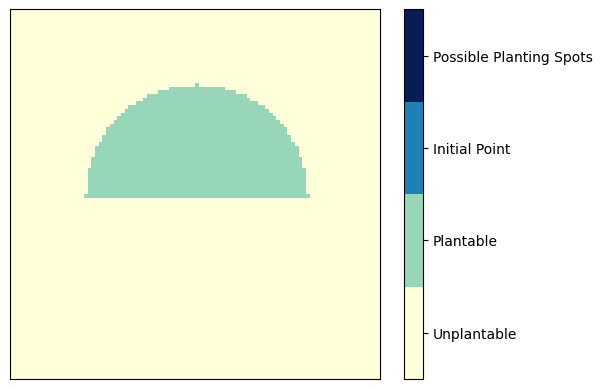

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def create_grid(grid_size, shape_type):
    # Initialize the grid with -1 (default to unplantable areas)
    grid = np.full((grid_size, grid_size), -1, dtype=np.int8)
    
    # Generate plantable areas based on the shape_type
    if shape_type == 'semicircle':
        grid = generate_semicircle(grid)
    elif shape_type == 'long_rectangle':
        grid = generate_long_rectangle(grid)
    elif shape_type == 'footpath':
        grid = generate_curved_footpath(grid)
    elif shape_type == 'square':
        grid = generate_square(grid)
    
    return grid

def generate_semicircle(grid, radius = 30):
    """Generates a plantable semicircle in the grid."""
    center = (50, 50)  # Center of the semicircle
    for x in range(grid.shape[0]):
        for y in range(grid.shape[1]):
            # Check if the point is inside the semicircle (top half)
            if (x - center[0])**2 + (y - center[1])**2 <= radius**2 and x <= center[0]:
                grid[x, y] = 0  # Mark as plantable (0)
    return grid

def generate_long_rectangle(grid, height = 40, width = 60):
    """Generates a long rectangle plantable area."""
    for x in range(50 - int(height/2), int(50 + height/2)):  # Height of the rectangle
        for y in range(int(50 - width/2), int(50 + width/2)):  # Width of the rectangle
            grid[x, y] = 0  # Mark as plantable (0)
    return grid

def generate_curved_footpath(grid):
    """Generates a plantable footpath with a smoother, eased curve and consistent width."""
    path_width = 20  # Footpath width

    # Smooth easing curve (quadratic/circular arc) with consistent width
    for i in range(90):
        x = i  # Shift along x-axis
        y = 20 + int(0.05 * (i**1.7))  # Quadratic easing curve for smoother turn
        for offset in range(-path_width // 2, path_width // 2 + 1):
            if 0 <= y + offset < grid.shape[1] and 0 <= x < grid.shape[0]:  # Ensure within bounds
                grid[x, y + offset] = 0  # Mark as plantable (0)
    
    return grid

def generate_square(grid, side_length = 60):
    """Generates a square plantable area."""
    top_left = (20, 20)  # Top-left corner of the square
    for x in range(top_left[0], top_left[0] + side_length):
        for y in range(top_left[1], top_left[1] + side_length):
            grid[x, y] = 0  # Mark as plantable (0)
    return grid
def render_grid(grid):
    """Render the grid using matplotlib with the correct order for grid values."""
    # Create a colormap with 4 distinct colors: -1 (unplantable), 0 (plantable), 1 (initial point), 2 (possible planting spots)
    cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value
    bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]  # Define bounds for color bar to segment values properly
    
    # Render the grid using imshow
    plt.imshow(grid, cmap=cmap, vmin=-1, vmax=2)
    
    plt.xticks([])  # Remove x-axis labels
    plt.yticks([])  # Remove y-axis labels
    
    # Create custom color bar with labels in the specified order
    cbar = plt.colorbar(ticks=[-1, 0, 1, 2], boundaries=bounds)
    cbar.ax.set_yticklabels(['Unplantable', 'Plantable', 'Initial Point', 'Possible Planting Spots'])
    
    plt.grid(False)  # Remove grid lines
    plt.show()
# Set the grid size to 100x100
grid_size = 100

# Create the grid with a specific shape


semicircle_grid = create_grid(grid_size, 'semicircle')
long_rectangle_grid = create_grid(grid_size, 'long_rectangle')
footpath_grid = create_grid(grid_size, 'footpath')
square_grid = create_grid(grid_size, 'square')

# render_grid(semicircle_grid)
# render_grid(long_rectangle_grid)
# render_grid(footpath_grid)
# render_grid(square_grid)

grids = {
    'semicircle': semicircle_grid,
    'rectangle': long_rectangle_grid,
    'curve': footpath_grid,
    'square': square_grid
}
def retrieve_grid(shape):
    """
        Returns the grid objects created with the initialisation function, will not be making copy bcos I assume what functions operate on tyhem will
        
        Parameters:
        - shape: either semicircle, rectangle, curve or square
    """
    return grids[shape]

render_grid(retrieve_grid('semicircle'))


## Code used to create a point on the grid

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\65751590.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value


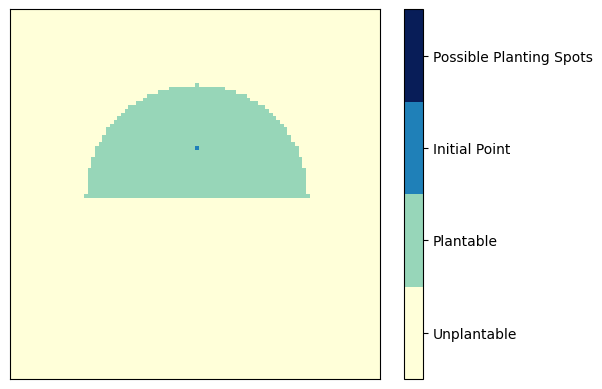

In [3]:
def place_initial_point(grid, x, y):
    """Places the initial point on a copy of the grid and returns the changed grid."""
    new_grid = np.copy(grid)  # Make a copy of the original grid
    if 0 <= x < new_grid.shape[0] and 0 <= y < new_grid.shape[1]:
        new_grid[x, y] = 1  # Mark as initial point (1)
    return new_grid  # Return the modified grid

semicircle_point = place_initial_point(retrieve_grid('semicircle'), 37, 50)
rectangle_point = place_initial_point(retrieve_grid('rectangle'), 50, 50)
curve_point = place_initial_point(retrieve_grid('curve'), 43, 50)
square_point = place_initial_point(retrieve_grid('square'), 50, 50)

grids_with_point = {
    'semicircle': (semicircle_point, (37,50)),
    'rectangle': (rectangle_point, (50,50)),
    'curve': (curve_point, (43, 50)),
    'square': (square_point, (50, 50))
}

render_grid(grids_with_point['semicircle'][0])

## Essentially trying to create a RL to classify shapes, wait CV

## Measuring distances

In [4]:
def measure_distances_to_unplantable(grid, x, y):
    """Measures the distance from the initial point (x, y) in all 8 directions to the nearest unplantable area."""
    directions = [
        (-1, 0),  # N
        (-1, 1),  # NE
        (0, 1),   # E
        (1, 1),   # SE
        (1, 0),   # S
        (1, -1),  # SW
        (0, -1),  # W
        (-1, -1)  # NW
    ]
    
    # Ensure the initial point is in a plantable area (0)
    if grid[x, y] != 1:
        raise ValueError("Initial point must be in a plantable area (value 0).")

    grid_size = grid.shape[0]  # Assuming a square grid

    # List to store distances to unplantable areas in each direction
    distances = []

    # For each direction, measure the distance to the nearest unplantable area
    for dx, dy in directions:
        step = 0
        current_x, current_y = x, y
        
        # Move in the direction until we hit the grid boundary or an unplantable area
        while 0 <= current_x < grid_size and 0 <= current_y < grid_size:
            step += 1
            current_x += dx
            current_y += dy
            
            # Check if we hit an unplantable area (-1)
            if 0 <= current_x < grid_size and 0 <= current_y < grid_size and grid[current_x, current_y] == -1:
                distances.append(step)
                break
        else:
            # If no unplantable area is found within bounds, mark as "infinity" (or a large number)
            distances.append(float('inf'))

    return distances


In [5]:
# print(measure_distances_to_unplantable(grids_with_point['semicircle'],37, 50))
# render_grid(grids_with_point['semicircle'])
# print(measure_distances_to_unplantable(grids_with_point['rectangle'],50, 50))
# render_grid(grids_with_point['rectangle'])
# print(measure_distances_to_unplantable(grids_with_point['curve'],43, 50))
# render_grid(grids_with_point['curve'])
# print(measure_distances_to_unplantable(grids_with_point['square'],50, 50))
# render_grid(grids_with_point['square'])

distances_to_change = {
    'semicircle': measure_distances_to_unplantable(grids_with_point['semicircle'][0],37, 50),
    'rectangle': measure_distances_to_unplantable(grids_with_point['rectangle'][0],50, 50),
    'curve': measure_distances_to_unplantable(grids_with_point['curve'][0],43, 50),
    'square': measure_distances_to_unplantable(grids_with_point['square'][0],50, 50)
}

print(distances_to_change)

{'semicircle': [18, 14, 28, 14, 14, 14, 28, 14], 'rectangle': [21, 21, 30, 20, 20, 20, 31, 21], 'curve': [10, 5, 10, 27, 9, 5, 12, 41], 'square': [31, 30, 30, 30, 30, 30, 31, 31]}


## Code for generating points

In [6]:
def rotate_vector(vector, angle):
    """Rotate the vector by the specified angle."""
    angle_rad = np.radians(angle)  # Convert angle to radians
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    return rotation_matrix @ vector  # Apply the rotation matrix to the vector

def collatz_grid_visualize(start_x, steps, start_tile=(5, 5), start_angle=0, odd_angle_deflection=45, distance=1, highlight_every_n=5, visualize=True):
    """Visualize the 3x + 1 rule on a grid, deflecting by a given angle when odd.
       The number of steps is determined by steps * highlight_every_n.
       Returns the list of positions and the highlighted nodes as a result."""
    
    x = start_x
    coords = [start_tile]  # Store coordinates for the grid movements
    current_pos = np.array(start_tile)  # Start from the given tile
    
    # Initialize direction as a unit vector in the given angle (0 degrees is upwards)
    current_dir = np.array([0, 1])  # 0 degrees corresponds to moving "up" in the y-axis

    # Rotate the initial vector based on the provided starting angle
    current_dir = rotate_vector(current_dir, start_angle)

    # List to store highlighted nodes
    highlighted_coords = []

    total_steps = steps * highlight_every_n  # Total steps now determined by the product

    for step in range(total_steps):
        if x == 0:
            print(f"Terminating: Reached value 0 at step {step}")
            break  # Terminate the process if x becomes 0

        # Move in the current direction scaled by the distance
        current_pos = current_pos + current_dir * distance
        # Store the rounded position for plotting and list
        rounded_pos = tuple(round(coord) for coord in current_pos)
        coords.append(rounded_pos)  # Store the new rounded position

        # Highlight every nth node (starting after the first move)
        if (step + 1) % highlight_every_n == 0:
            highlighted_coords.append(rounded_pos)

        if x % 2 != 0:
            # Rotate the direction by the specified deflection angle if odd
            current_dir = rotate_vector(current_dir, odd_angle_deflection)

        # Calculate next number in the Collatz sequence
        if x % 2 == 0:
            x = x // 2  # If even, divide by 2
        else:
            x = 3 * x + 1  # If odd, apply 3x + 1

    # If visualize is enabled, plot the grid and highlighted nodes
    if visualize:
        # Extract x and y values for plotting (already rounded)
        x_vals, y_vals = zip(*coords)

        # Plotting the grid and the movements
        plt.figure(figsize=(8, 8))
        plt.plot(x_vals, y_vals, marker='o', color='b', label=f"Collatz Movement starting at {start_x}")
        
        # Highlight the starting point
        plt.scatter([start_tile[0]], [start_tile[1]], color='red', s=100, label="Start")
        
        # Highlight every nth node (using the same rounded coordinates)
        for i, (x_val, y_val) in enumerate(zip(x_vals, y_vals)):
            if i % highlight_every_n == 0 and i != 0:  # Make sure not to highlight the 0th index if unwanted
                plt.scatter(x_val, y_val, color='green', s=150, label=f"Node {i}" if i == 0 else "")  # First one gets a label

        plt.title(f"Collatz Grid Visualization (Deflection Angle: {odd_angle_deflection}°)")
        plt.xlabel("Grid X")
        plt.ylabel("Grid Y")
        plt.grid(True)
        plt.legend()
        plt.gca().set_aspect('equal', adjustable='box')  # Ensure square aspect ratio for the grid
        plt.show()

    # Return the list of highlighted nodes
    return highlighted_coords

## Function used for training and creating the visualisations

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from gymnasium import spaces, Env

In [26]:
class CustomGridEnv(Env):
    """Custom Grid environment with continuous action space for PPO, capable of handling multiple shapes."""
    
    def __init__(self, grids_with_point, distances_to_change, max_angle=0):
        super(CustomGridEnv, self).__init__()
        
        self.grids_with_point = grids_with_point  # Dictionary of grids with points for each shape
        self.distances_to_change = distances_to_change  # Dictionary of distances for each shape
        self.num_objects = 5
        self.grid_size = next(iter(grids_with_point.values()))[0].shape[0]  # Assuming all grids are the same size
        
        # Continuous action space: A combination of the inputs used in the function (Box space)
        self.distinct_values = np.array([1, 17, 51, 101])
        self.tress_range = np.arange(2, 11)
        self.starting_angles = np.array([0,45,90,135,180,225,270,315])        
        self.angle_values = np.array([1, 5, 22.5, 45, 75])
        self.distances_range = np.arange(1, 6) 

        self.action_space = spaces.MultiDiscrete([  # Action space for PPO
            len(self.distinct_values),  # start_x index
            len(self.tress_range),      # tress (range 2-10)
            len(self.starting_angles),
            len(self.angle_values),     # odd_angle_deflection
            len(self.distances_range)   # distance (range 1-5)
        ])
        
        # Observation space: The grid, flattened, plus a value representing the current shape and the distances
        self.observation_space = spaces.Dict({
            'grid': spaces.Box(low=-1, high=2, shape=(self.grid_size * self.grid_size,), dtype=np.float32),
            'shape': spaces.Discrete(4),  # 4 shapes: semicircle, rectangle, curve, square
            'distances': spaces.Box(low=0, high=np.inf, shape=(8,), dtype=np.float32)  # 8 distances (one for each direction)
        })
        
        self.seed_val = None  # To store seed if provided
        self.current_shape = None
        self.point_to_place = None
        self.placed_grid = None
        self.current_distances = None

    def reset(self, seed=None):
        """Resets the environment, randomly chooses a shape, and returns the initial observation."""
        if seed is not None:
            self.seed_val = seed
            np.random.seed(seed)
        
        # Randomly select a shape from the grids_with_point dictionary
        self.current_shape = np.random.choice(list(self.grids_with_point.keys()))
        self.placed_grid, self.point_to_place = self.grids_with_point[self.current_shape]
        self.current_distances = self.distances_to_change[self.current_shape]  # Retrieve corresponding distances
        
        self.grid = np.copy(self.placed_grid)  # Reset to the base grid with unplantable areas
        self.current_object = 0  # Track how many objects have been placed
        self.placed_positions = set()  # Keep track of placed positions

        # Shape value mapping to observation space
        shape_mapping = {'semicircle': 0, 'rectangle': 1, 'curve': 2, 'square': 3}
        shape_value = shape_mapping[self.current_shape]

        # Return both the grid, shape, and distances as observation, and an empty dictionary as info
        return {
            'grid': self.grid.flatten(),
            'shape': shape_value,
            'distances': np.array(self.current_distances)  # Return the 8 distances as an array
        }, {}

    def step(self, action):
        """Takes an action based on the current shape, modifies inputs to the Collatz function, and evaluates the reward."""
        start_x = self.distinct_values[action[0]]  # Select the corresponding distinct value
        tress = self.tress_range[action[1]]  # Use the selected value from tress range (2-10)
        angle = self.starting_angles[action[2]]
        odd_angle_deflection = self.angle_values[action[3]]  # Use the selected angle
        distance = self.distances_range[action[4]]         

        # Use the collatz function to generate points (e.g., generate based on shape)
        collatz_points = collatz_grid_visualize(start_x, int(tress), start_tile=self.point_to_place, 
                                                start_angle=angle, odd_angle_deflection=odd_angle_deflection, 
                                                distance=distance, visualize=False)
        
        reward = 0
        
        # Check if generated points fall within the correct areas and reward/penalize
        for point in collatz_points:
            if (0 <= point[0] < self.grid_size and 0 <= point[1] < self.grid_size) and \
               (self.placed_grid[point[0], point[1]] == self.placed_grid[self.point_to_place[0] + 1, self.point_to_place[1]]):
                reward += 1  # Reward for planting correctly
                self.grid[point[0], point[1]] = 2  # Mark the plant on the grid as '2' (tree)
            else:
                reward -= 1  # Penalize for planting in the wrong area

        done = self.current_object == self.num_objects
        terminated = done
        truncated = False

        # Shape value mapping
        shape_mapping = {'semicircle': 0, 'rectangle': 1, 'curve': 2, 'square': 3}
        shape_value = shape_mapping[self.current_shape]

        # Return updated observation with the grid, shape, and distances
        return {
            'grid': self.grid.flatten(),
            'shape': shape_value,
            'distances': np.array(self.current_distances)  # Return the 8 distances as an array
        }, reward, terminated, truncated, {}

    def render(self):
        """Render the grid using matplotlib with the trees placed."""
        cmap = plt.cm.get_cmap("YlGnBu", 4)  # Set a colormap for the four possible values
        plt.imshow(self.grid, cmap=cmap, vmin=-1, vmax=2)  # Make sure to set the color range to cover all grid values
        plt.title(f"Grid with Plants Placed ({self.current_shape})")
        plt.xticks([])  # Remove x-axis labels
        plt.yticks([])  # Remove y-axis labels
        plt.grid(False)
        # Custom colorbar labels for each tag value (-1: Unplantable, 0: Plantable, 1: Initial Point, 2: Trees)
        cbar = plt.colorbar(ticks=[-1, 0, 1, 2])
        cbar.ax.set_yticklabels(['Unplantable', 'Plantable', 'Initial Point', 'Trees'])
        plt.show()


In [27]:
import torch
from stable_baselines3 import PPO

def train_model_for_all_shapes(grids_with_point, distances_to_change, max_angle, total_timesteps=100000):
    """
    Trains a PPO model on the CustomGridEnv for multiple shapes using GPU if available.
    
    Parameters:
        grids_with_point: dict
            A dictionary containing grids and their respective points for each shape.
        distances_to_change: dict
            A dictionary containing distances for each shape in 8 directions.
        max_angle: float
            The maximum angle used for action generation.
        total_timesteps: int
            Total timesteps to train the model.
    """
    
    # Check if GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Create an instance of the custom environment with all shapes
    env = CustomGridEnv(grids_with_point, distances_to_change, max_angle)
    
    # Initialize PPO model with MultiInputPolicy (to handle dict observation space)
    model = PPO("MultiInputPolicy", env, verbose=1, device=device)  # Specify device here

    # Train the model for the specified number of timesteps
    model.learn(total_timesteps=total_timesteps)

    # Save the trained model
    model.save("ppo_grid_plant_placement_all_shapes")

    print("Training completed and model saved for all shapes!")


In [29]:
# grids_with_point = {'semicircle': (semicircle_grid, semicircle_point), 'rectangle': (rectangle_grid, rectangle_point), ...}

# print(grids_with_point)
# print( distances_to_change)
# Example usage for training and visualizing
train_model_for_all_shapes(grids_with_point, distances_to_change, 0)


Using device: cuda
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 259  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 210         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017490603 |
|    clip_fraction        | 0.286       |
|    clip_range           | 0.2         |
|    entropy_loss         | -8.86       |
|    explained_variance   | 0.00469     |
|    learning_rate        | 0.0003      |
|    loss                 | 231         |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0321     |
|   

In [30]:
from stable_baselines3 import PPO

def visualize_model_for_single_shape(grid_with_point, distances_to_change, shape, max_angle=0, model_path="ppo_grid_plant_placement_all_shapes"):
    """
    Visualizes the placement of plants using the trained PPO model for a single shape.

    Parameters:
        grid_with_point: tuple
            A tuple containing the grid and the initial point to place for a specific shape.
        distances_to_change: list
            A list of distances in 8 directions for the current shape.
        max_angle: float
            The maximum angle used for action generation (default is 0).
        model_path: str
            The path to the trained model (default is "ppo_grid_plant_placement_all_shapes").
    """
    
    # Load the trained model
    model = PPO.load(model_path)

    # Extract the grid and point from grid_with_point tuple
    grid, point_to_place = grid_with_point  # Unpack the grid and initial point
    
    # Prepare the environment for this specific shape
    grids_with_point = {shape: (grid, point_to_place)}
    distances_to_change_dict = {shape: distances_to_change}

    # Create an instance of the custom environment for visualization
    env = CustomGridEnv(grids_with_point, distances_to_change_dict, max_angle)

    # Reset the environment
    obs, _ = env.reset()

    # Run the trained model on the environment and visualize the process
    for x in range(env.num_objects):  # Iterate through the number of objects to place
        # Predict the next action using the model
        action, _states = model.predict(obs)
        
        # Take the action in the environment
        obs, reward, done, truncated, info = env.step(action)

        # Render the current state of the grid after each step
        if x == env.num_objects -1:
            env.render()

        # Stop if the task is done (i.e., all objects have been placed)
        if done:
            break


C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\65751590.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value


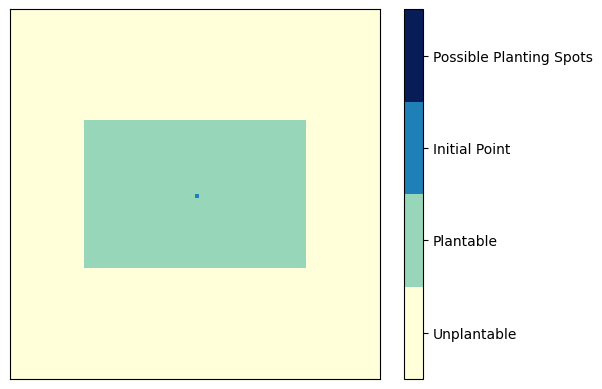

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\2431791456.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Set a colormap for the four possible values


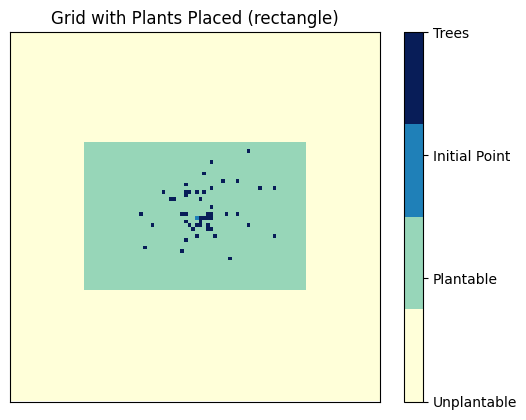

In [44]:
# Example input for visualizing the rectangle grid and distances
grids_with_point_testing_2 = {
    'rectangle': (long_rectangle_grid, (50, 50))  # Grid and point for 'rectangle'
}

distances_to_change_2 = {
    'rectangle': [21, 21, 30, 20, 20, 20, 31, 21]  # Corresponding distances for 'rectangle'
}

# Call the visualization function for the 'rectangle' shape
render_grid(grids_with_point['rectangle'][0])

visualize_model_for_single_shape(grids_with_point['rectangle'], distances_to_change['rectangle'], 'rectangle', max_angle=0)


C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\2431791456.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Set a colormap for the four possible values


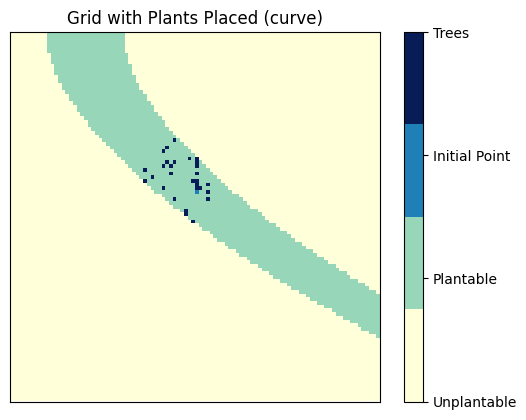

In [43]:
visualize_model_for_single_shape(grids_with_point['curve'], distances_to_change['curve'], 'curve', max_angle=0)


C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\2431791456.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Set a colormap for the four possible values


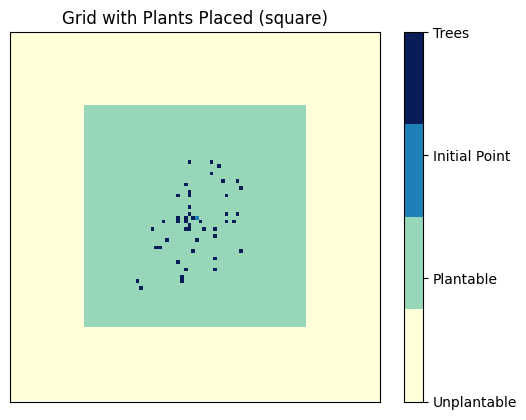

In [39]:
visualize_model_for_single_shape(grids_with_point['square'], distances_to_change['square'], 'square', max_angle=0)

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\2431791456.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Set a colormap for the four possible values


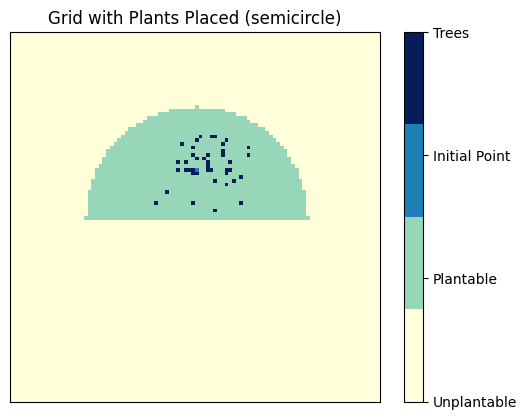

In [38]:
visualize_model_for_single_shape(grids_with_point['semicircle'], distances_to_change['semicircle'], 'semicircle', max_angle=0)

## Possibility of edge segmentation?

What needs to be done is to try and create a straight row of trees, based on the shape, what if try to use CV to extract features and use those to generate the shape

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\65751590.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value


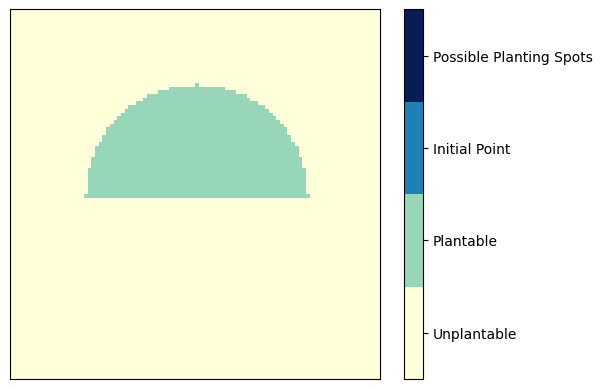

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\65751590.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value


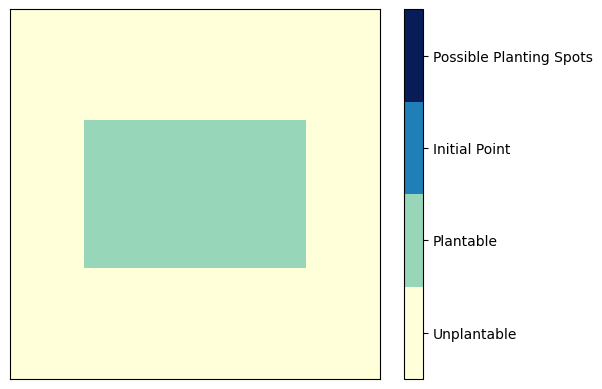

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\65751590.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value


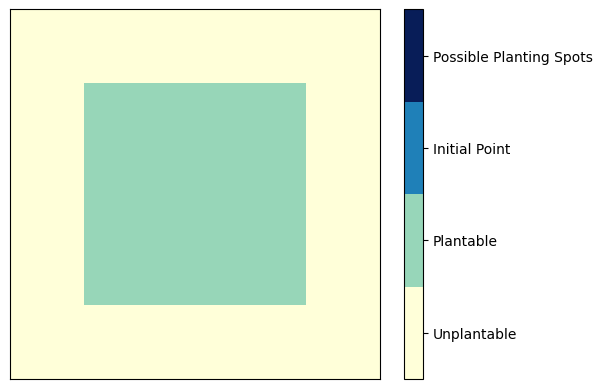

C:\Users\yongl\AppData\Local\Temp\ipykernel_23620\65751590.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlGnBu", 4)  # Using 'tab10' to have distinct colors for each value


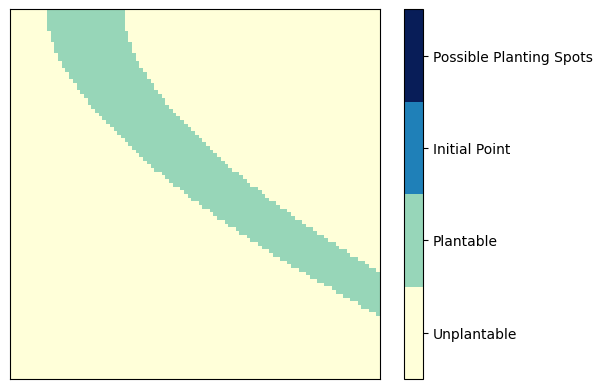

In [47]:
render_grid(retrieve_grid('semicircle'))
render_grid(retrieve_grid('rectangle'))
render_grid(retrieve_grid('square'))
render_grid(retrieve_grid('curve'))


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_normals(contour, length=20):
    """
    Calculate normals for each segment of the contour.
    
    Parameters:
    - contour: The contour of the shape (numpy array).
    - length: Length of the normals to be drawn.
    
    Returns:
    - A list of tuples (start_point, end_point) representing the normals.
    """
    normals = []
    
    for i in range(len(contour) - 1):
        # Get current and next point
        point1 = contour[i][0]
        point2 = contour[i + 1][0]
        
        # Calculate the direction vector between the two points
        direction = np.array(point2) - np.array(point1)
        
        # Calculate the normal (perpendicular) vector
        normal = np.array([-direction[1], direction[0]])  # Perpendicular to direction
        normal = normal / np.linalg.norm(normal)  # Normalize the vector
        
        # Create the normal line from the midpoint of the segment
        midpoint = (point1 + point2) / 2
        start_point = midpoint
        end_point = midpoint + normal * length
        
        normals.append((tuple(start_point.astype(int)), tuple(end_point.astype(int))))
    
    return normals

def draw_normals_on_array(array, contours):
    """
    Draw normals on the array based on the contours.
    
    Parameters:
    - array: The input numpy array.
    - contours: The contours of the shapes detected.
    """
    # Convert the array to an image
    image = np.copy(array)
    
    # Iterate over each contour and calculate normals
    for contour in contours:
        normals = calculate_normals(contour)
        
        # Draw each normal on the image
        for start_point, end_point in normals:
            cv2.line(image, start_point, end_point, (255, 0, 0), 1)  # Draw the normals
    
    return image

def main():
    # Example: Load a binary numpy array (simulate with a numpy array filled with 0s and 1s)
    array = np.zeros((100, 100), dtype=np.uint8)
    
    # Create a rectangle in the array (1s represent the shape)
    cv2.rectangle(array, (20, 20), (80, 80), 1, -1)
    
    # Detect the contours of the shape
    contours, _ = cv2.findContours(array, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the normals on the array
    output_image = draw_normals_on_array(array, contours)
    
    # Visualize the result
    plt.imshow(output_image, cmap='gray')
    plt.show()

if __name__ == "__main__":
    main()


ModuleNotFoundError: No module named 'cv2'